In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely import geometry, ops
import matplotlib.pyplot as plt

%matplotlib inline

# Read in data from shapefiles

In [2]:
# Read in the datasets
streets0 = gpd.read_file('./sourcedata/streets/StatePlane/Street_Network_Database.shp')
sidewalks0 = gpd.read_file('./sourcedata/sidewalks/Sidewalks/Sidewalks.shp')

# Standardize datasets

In [3]:
# Strip metadata from new sidewalks/streets tables
streets = streets0.copy()[['COMPKEY', 'geometry']]

# Convert all sidewalks to LineStrings (also filters out invalid geometries)
sidewalk_cols = ['COMPKEY', 'SEGKEY', 'CURBRAMPHI', 'CURBRAMPLO', 'geometry']
sidewalks = sidewalks0[sidewalks0.geometry.type == 'LineString'].copy()[sidewalk_cols]

newrows = []
for i, row in sidewalks0[sidewalks0.geometry.type == 'MultiLineString'].iterrows():
    for geom in row.geometry:
        newrows.append(row.copy()[sidewalk_cols])
        newrows[-1].geometry = geom
sidewalks = pd.concat([sidewalks, gpd.GeoDataFrame(newrows)])

sidewalks.rename(columns={'CURBRAMPHI': 'curbramp_end', 'CURBRAMPLO': 'curbramp_start'}, inplace=True)

# This created duplicate indices, which currently have no meaning - reset the index
# and create a column for it
sidewalks.reset_index(drop=True, inplace=True)
sidewalks.reset_index(inplace=True)
streets.reset_index(inplace=True)

In [4]:
# Create curbramps table based on sidewalks
curbend = sidewalks[sidewalks['curbramp_end'] == 'Y']
curbstart = sidewalks[sidewalks['curbramp_start'] == 'Y']

curbramps = gpd.GeoDataFrame(pd.concat([curbend.geometry.apply(lambda x: geometry.Point(x.coords[-1])), 
                                        curbstart.geometry.apply(lambda x: geometry.Point(x.coords[0]))]))

curbramps['SW_COMPKEY'] = pd.concat([curbend['COMPKEY'], curbstart['COMPKEY']])
curbramps['endtype'] = curbend.shape[0] * ['end'] + curbstart.shape[0] * ['start']

curbramps.head()

geometry  SW_COMPKEY endtype
0   POINT (1281705.930926725 269032.0037278831)      330518     end
7    POINT (1264537.764147639 247666.632744804)      330261     end
10  POINT (1274390.088274971 195873.9157923907)      330341     end
22   POINT (1274408.131217897 195910.732319802)      330342     end
24  POINT (1263916.749969721 247684.8416978866)      330262     end

In [5]:
# Remove sidewalks that are almost exactly their streets - this happens when bad 'width'
# data was used to extrapolate sidewalks

print sidewalks.shape

sdw_st = pd.merge(sidewalks, streets, left_on='SEGKEY', right_on='COMPKEY')

def geoms_differ(geoseries, tol=0.1):
    x = np.array(geoseries['geometry_x'].coords)
    y = np.array(geoseries['geometry_y'].coords)

    if x.shape != y.shape:
        return True
    if abs(x - y).sum() > tol:
        return True
    else:
        return False

sdw_st_clean = sdw_st[sdw_st.apply(geoms_differ, axis=1)]
sidewalks = sidewalks[sidewalks['COMPKEY'].isin(sdw_st_clean['COMPKEY_x'])]

print sidewalks.shape

(45587, 6)
(45583, 6)


# Trim sidewalk lines that intersect streets

In [6]:
# CRS is forgotten during some operations, re-copy
streets.crs = streets0.crs
sidewalks.crs = sidewalks0.crs

# Trim sidewalk lines that intersects streets - keep the side that's on the centroid of the line
overlapping = gpd.sjoin(sidewalks[['index', 'geometry']], 
                        streets[['index', 'geometry']], 
                        how='inner', 
                        op='intersects', 
                        lsuffix='sw', 
                        rsuffix='st')
# For some reason, the sjoin function makes two index_st columns. Drop one
index_st = overlapping['index_st'].iloc[:, 0]
overlapping.drop('index_st', 1, inplace=True)
overlapping['index_st'] = index_st

# The streets geometry column gets dropped, need to reselect it
overlapping['geometry_st'] = streets.loc[overlapping['index_st']]['geometry'].tolist()

print overlapping.shape
overlapping.head()

(6575, 4)


index_sw                                           geometry  index_st  \
0            0  LINESTRING (1281458.343495399 269038.231733799...     33635   
8315      8315  LINESTRING (1281685.071060315 268401.527626633...     33635   
10          10  LINESTRING (1273755.200765222 196185.057886630...     27780   
3135      3135  LINESTRING (1273757.456666231 195899.382276877...     27780   
22          22  LINESTRING (1273773.243708149 196221.874414056...     27842   

                                            geometry_st  
0     LINESTRING (1281705.553469256 268388.520134866...  
8315  LINESTRING (1281705.553469256 268388.520134866...  
10    LINESTRING (1274222.527541593 195978.058108732...  
3135  LINESTRING (1274222.527541593 195978.058108732...  
22    LINESTRING (1274381.976117745 195928.646780669...

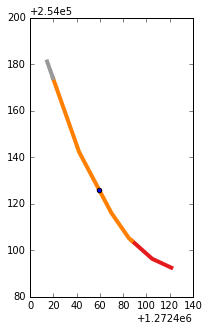

In [36]:
# Example - the central line would be kept, the others discarded
split = overlapping.loc[62, 'geometry'].iloc[0].difference(geometry.MultiLineString(list(overlapping.loc[62, 'geometry_st']))).geoms
ax1 = gpd.GeoSeries(split).plot(linewidth=4)
ax1.set_aspect(2)

split_mid = overlapping.loc[62, 'geometry'].iloc[0].interpolate(0.5, normalized=True)

plt.scatter(split_mid.x, split_mid.y, zorder=10)

fig = plt.gcf()
fig.set_size_inches(5, 5)

In [67]:
def trim_sidewalk(group, tol=1e-7, threshold=0.6):
    '''Given sidewalk and street geometries, return the midpoint-containing
    sidewalk segment.'''
    changed = False
    
    index_sw = group['index_sw'].iloc[0]
    sidewalk = group['geometry'].iloc[0]
    street = geometry.MultiLineString(list(group['geometry_st']))

    split = sidewalk.difference(street).geoms
    
    # First, let's just try removing the two end pieces
    startpoint = sidewalk.coords[0]
    endpoint = sidewalk.coords[-1]
    trimmed_list = []
    for line in split:
        if startpoint not in line.coords and endpoint not in line.coords:
            trimmed_list.append(line)
        else:
            if (line.length / sidewalk.length) > 0.05:
                # dangles less than 5% of the total length will be removed
                # FIXME: this should be an absolute length instead of relative
                trimmed_list.append(line)  
    
            
    if len(trimmed_list) != len(split):
        changed = True
        trimmed = ops.linemerge(trimmed_list)
    else:
        # No changes were made - try other strategy


        # If that didn't work, let's try trimming to just the central piece
        def point_on_line(line, point):
            return line.distance(point) < tol

        midpoint = sidewalk.interpolate(0.5, normalized=True)
        mid_containing = [line for line in split if point_on_line(line, midpoint)]
        if not mid_containing:
            raise Exception('Segment did not contain centroid')
        if len(mid_containing) > 1:
            raise Exception('Multiple lines contained centroid')

        # Quality control: only alter the sidewalk line if it's a relatively
        # minor change - i.e. the central piece is quite large
        if (mid_containing[0].length / sidewalk.length) > threshold:
            changed = True
            trimmed = mid_containing[0]
        else:
            trimmed = sidewalk

    # Trim the ends slightly (0.1%) to ensure future non-intersection
    first = trimmed.interpolate(0.001, normalized=True)
    last = trimmed.interpolate(0.999, normalized=True)
    
    trimmed_arr = list(trimmed.coords)
    trimmed_arr[0] = (first.x, first.y)
    trimmed_arr[-1] = (last.x, last.y)
    
    trimmed = geometry.LineString(trimmed_arr)
    
    return gpd.GeoDataFrame({'index_sw': [index_sw], 
                             'geometry': [trimmed],
                             'changed': changed})        
    


fixed_sw = overlapping.groupby('index_sw').apply(trim_sidewalk).unstack()
fixed_sw.columns = fixed_sw.columns.get_level_values(0)
fixed_sw.index.name = ''

# Update the geometry column for sidewalks that intersected
sidewalks.update(fixed_sw)

fixed_sw.head()

changed                                           geometry  index_sw
                                                                       
0     True  LINESTRING (1281459.662926852 269038.198543798...         0
10    True  LINESTRING (1273755.659928091 196184.832862678...        10
22    True  LINESTRING (1273773.872082346 196221.566463969...        22
33    True  LINESTRING (1284868.459787216 257425.080260911...        33
34    True  LINESTRING (1273411.161788395 196482.143941772...        34

In [74]:
# Report how many are still 'intersecting', i.e. would've been cut into too small of pieces
intersecting = gpd.sjoin(sidewalks[['index', 'geometry']], 
                         streets[['index', 'geometry']], 
                         how='inner', 
                         op='intersects', 
                         lsuffix='sw', 
                         rsuffix='st')

changed = gpd.GeoDataFrame(fixed_sw[fixed_sw['changed']])

print 'Intersecting: ', intersecting.shape
print 'Changed: ', changed.shape
print 'Total: ', fixed_sw.shape

Intersecting:  (1805, 4)
Changed:  (4492, 3)
Total:  (4931, 3)


In [78]:
remaining.to_file('remaining.shp')
changed['changed'] = changed['changed'].astype(int)
fixed_sw['changed'] = fixed_sw['changed'].astype(int)
changed.to_file('changed.shp')
gpd.GeoDataFrame(fixed_sw).to_file('total.shp')

# Create street intersections table

In [10]:
# Create 'intersections' table

st_ends = gpd.GeoDataFrame(pd.concat([streets.geometry.apply(lambda l: geometry.Point(l.coords[0])),
                           streets.geometry.apply(lambda l: geometry.Point(l.coords[0]))]))
st_ends['COMPKEY'] = streets['COMPKEY']

st_ends['wkt'] = st_ends['geometry'].apply(lambda l: l.wkt)
intersections = pd.DataFrame(st_ends.groupby('wkt').size().rename('streets'))
intersections.reset_index(level=0, inplace=True)
intersections = gpd.GeoDataFrame(pd.merge(intersections, st_ends[['wkt', 'geometry']], on='wkt'))
intersections = intersections[['geometry', 'streets']]

In [11]:
intersections

geometry  streets
0      POINT (1246804.081945509 245042.2253269702)        4
1      POINT (1246804.081945509 245042.2253269702)        4
2      POINT (1246804.081945509 245042.2253269702)        4
3      POINT (1246804.081945509 245042.2253269702)        4
4      POINT (1249026.115867794 213823.8997910023)        2
5      POINT (1249026.115867794 213823.8997910023)        2
6      POINT (1249067.764763832 214423.4034076184)        4
7      POINT (1249067.764763832 214423.4034076184)        4
8      POINT (1249067.764763832 214423.4034076184)        4
9      POINT (1249067.764763832 214423.4034076184)        4
10      POINT (1249256.945180029 213623.775118798)        2
11      POINT (1249256.945180029 213623.775118798)        2
12     POINT (1249272.682268038 213985.0146711618)        2
13     POINT (1249272.682268038 213985.0146711618)        2
14     POINT (1249455.628316224 245123.7899990529)        2
15     POINT (1249455.628316224 245123.7899990529)        2
16     POINT (1249608.985884383 245046.9838549644)        2
17     POINT (1249608.985884383 245046.9838549644)        2
18     POINT (1249648.231196418 214434.6405276209)        2
19     POINT (1249648.231196418 214434.6405276209)        2
20     POINT (1249744.353820518 213491.5941266567)        2
21     POINT (1249744.353820518 213491.5941266567)        2
22     POINT (1249798.556700572 214488.7410076857)        4
23     POINT (1249798.556700572 214488.7410076857)        4
24     POINT (1249798.556700572 214488.7410076857)        4
25     POINT (1249798.556700572 214488.7410076857)        4
26     POINT (1249805.500188589 214115.6995992959)        2
27     POINT (1249805.500188589 214115.6995992959)        2
28      POINT (1249981.55394876 214561.6743837595)        2
29      POINT (1249981.55394876 214561.6743837595)        2
...                                            ...      ...
67948  POINT (1297841.348173767 180260.2105406225)        4
67949  POINT (1297841.348173767 180260.2105406225)        4
67950  POINT (1297851.874637783 180822.2590532005)        4
67951  POINT (1297851.874637783 180822.2590532005)        4
67952  POINT (1297851.874637783 180822.2590532005)        4
67953  POINT (1297851.874637783 180822.2590532005)        4
67954  POINT (1297865.179981798 181135.3288775235)        2
67955  POINT (1297865.179981798 181135.3288775235)        2
67956  POINT (1297891.016781822 178910.9016112536)        2
67957  POINT (1297891.016781822 178910.9016112536)        2
67958    POINT (1297957.69300589 179232.660843581)        4
67959    POINT (1297957.69300589 179232.660843581)        4
67960    POINT (1297957.69300589 179232.660843581)        4
67961    POINT (1297957.69300589 179232.660843581)        4
67962  POINT (1298075.549262017 180825.0481732041)        4
67963  POINT (1298075.549262017 180825.0481732041)        4
67964  POINT (1298075.549262017 180825.0481732041)        4
67965  POINT (1298075.549262017 180825.0481732041)        4
67966   POINT (1298160.034894094 180039.586668402)        4
67967   POINT (1298160.034894094 180039.586668402)        4
67968   POINT (1298160.034894094 180039.586668402)        4
67969   POINT (1298160.034894094 180039.586668402)        4
67970  POINT (1298196.638542131 178274.4469545931)        2
67971  POINT (1298196.638542131 178274.4469545931)        2
67972   POINT (1298240.45319818 179213.8571315557)        4
67973   POINT (1298240.45319818 179213.8571315557)        4
67974   POINT (1298240.45319818 179213.8571315557)        4
67975   POINT (1298240.45319818 179213.8571315557)        4
67976  POINT (1298251.854926199 178042.5808423609)        2
67977  POINT (1298251.854926199 178042.5808423609)        2

[67978 rows x 2 columns]

In [12]:
hull = geometry.MultiLineString(list(streets.geometry)).convex_hull.exterior.coords
hull_lines = [geometry.LineString([hull[i], hull[i + 1]]) for i in range(len(hull) - 1)]
streets_and_hull = list(streets.geometry) + hull_lines

blocks = gpd.GeoDataFrame(geometry=list(ops.polygonize(streets_and_hull)))

In [13]:
blocks.crs = streets0.crs
blocks = blocks.to_crs({'init': 'epsg:4326'})
blocks.to_file('./blocks.shp')

In [14]:
polys, dangles, cuts, invalid = [gpd.GeoDataFrame(geometry=list(result)) for result in ops.polygonize_full(streets_and_hull)]

In [15]:
dangles.crs = streets0.crs
cuts.crs = streets0.crs
invalid.crs = streets0.crs

dangles.to_crs({'init': 'epsg:4326'})
cuts.to_crs({'init': 'epsg:4326'})
invalid.to_crs({'init': 'epsg:4326'})

dangles.to_file('./dangles.shp')
cuts.to_file('./cuts.shp')
invalid.to_file('./invalid.shp')

In [16]:
ops.polygonize(ops.cascaded_union(list(invalid.geometry)))

<generator object polygonize at 0x7f4a8cb9ce10>

In [17]:
invalid.shape

(32, 1)

In [18]:
invalid['wkt'] = invalid.geometry.apply(lambda l: l.wkt)
streets_and_hull['wkt'].isin(invalid)

TypeError: list indices must be integers, not str

In [ ]:
streets_and_hull